<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:10px 5px'> 
Master Thesis Yannik Haller - LDA for Covid Articles
</h1>
</div>

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
1. Load required packages and the data
</h2>
</div>

In [1]:
# Import required baseline packages
import re
import os
import glob
import time
import sys
import pandas as pd
import numpy as np
from pprint import pprint
from operator import itemgetter 

# Change pandas' setting to print out long strings
pd.options.display.max_colwidth = 200

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Spacy (for lemmatization)
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
# Set global parameters for plotting
import matplotlib.pylab as pylab
params = {'legend.fontsize': 10,
          'figure.figsize': (8, 6),
          'axes.labelsize': 14,
          'axes.titlesize': 16,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10}
pylab.rcParams.update(params)

# Regression and smoothing tools
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold

# Enable logging for gensim (optional)
import logging
logging.basicConfig(format = '%(asctime)s : %(levelname)s : %(message)s', level = logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
warnings.filterwarnings("ignore", category = FutureWarning)

C:\Users\Hallk\AppData\Roaming\Python\Python37\site-packages\ipykernel\pylab\config.py:70: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [2]:
# Set the appropriate working directory
os.chdir('D:\\Dropbox\\MA_data')

In [3]:
# Define a function to read in the fully preprocessed data (unigrams)
def read_preprocessed(language, tokenize = True):
    # Raise an error if an inadmissible language is chosen
    allowed_languages = ['de', 'en', 'fr', 'it']
    if language not in allowed_languages:
        raise ValueError("Invalid language. Expected one of: %s" % allowed_languages)
    
    # Set the appropriate working directory
    os.chdir('D:\\Dropbox\\MA_data')

    # Define the name of the file to load
    filename = "Preprocessed/"+language+"_preprocessed.csv"

    # Read in the dataframe containing the text data
    tx_pp = pd.read_csv(filename, index_col = 0, dtype = {'tx': object})

    # Get the articles' index together with an enumeration to identify their position in the list of precleaned articles
    idx = tx_pp.index
    idx = pd.DataFrame(idx, columns = [language+'_idx'])

    # Reduce the dataframe to a list containing the text data
    tx_pp = tx_pp.tx.to_list()

    # Tokenize the data again if tokenize = True (RAM-saving)
    if tokenize:
        tx_pp = retokenize(tx_pp)

    # Return the preprocessed data
    return tx_pp, idx

# Define a function to retokenize the preprocessed text data (RAM-saving)
def retokenize(article_list):
    for i in range(len(article_list)):
        temp_tx = str(article_list[i]).split()
        article_list[i] = temp_tx
    return article_list

In [4]:
# Define a function to read in the preprocessed fulltext data
def read_preprocessed_fulltext(language):
    # Raise an error if an inadmissible language is chosen
    allowed_languages = ['de', 'en', 'fr', 'it']
    if language not in allowed_languages:
        raise ValueError("Invalid language. Expected one of: %s" % allowed_languages)
    
    # Set the appropriate working directory
    os.chdir('D:\\Dropbox\\MA_data')

    # Define the name of the file to load
    filename = "Preprocessed/Fulltext/"+language+"_fulltext.csv"

    # Read in the data
    tx_ft = pd.read_csv(filename, index_col = 0, dtype = {'tx': object})

    # Get the articles' index together with an enumeration to identify their position in the list of precleaned articles
    idx = tx_ft.index
    idx = pd.DataFrame(idx, columns = [language+'_idx'])

    # Extract the text data as a list of articles
    tx_ft = tx_ft.tx.to_list()

    # Return the preprocessed data
    return tx_ft, idx

In [5]:
# Read in the aticles Metadata
articles = pd.read_csv("Analysis/articles_main.csv", index_col = 0, usecols = [0,11,12,13,14,15,16])
# Take a look at the dataframe
articles

,Topic_ID_1,Affiliation_Prob_1,Topic_ID_2,Affiliation_Prob_2,Topic_1,Topic_2
0,1,0.329300,7.0,0.292654,politics_international,economy_international
1,7,0.462487,11.0,0.269677,economy_international,economy_national
2,7,0.325522,11.0,0.232608,economy_international,economy_national
3,7,0.473720,11.0,0.470850,economy_international,economy_national
4,7,0.598861,11.0,0.281546,economy_international,economy_national
...,...,...,...,...,...,...
2441178,17,0.466716,2.0,0.251594,economy_national,inconsequential
2441179,12,0.315961,21.0,0.274781,inconsequential,economy_national
2441180,26,0.377586,29.0,0.296713,sports,law_order
2441181,23,0.433544,13.0,0.272896,tragedies_crimes,law_order


In [6]:
# Get the indexes of the articles that are about Covid (i.e. either articles with Topic_1 = COVID or Topic_2 = COVID and Affiliation_Prob_2 >= 0.25)
Covid_idx = articles.loc[np.logical_or(articles['Topic_1'] == 'COVID', 
                                       np.logical_and(articles['Topic_2'] == 'COVID', 
                                                      articles['Affiliation_Prob_2'] >= 0.25))].index
# Remove the unnecessary variable to save RAM
del articles

In [7]:
# Read in the preprocessed data
it_tx, it_idx = read_preprocessed('it')

# Take a look at the size of the precleaned data
sys.getsizeof(it_tx)

189032

In [8]:
## Reduce the data to the Covid articles
# Retrieve the location of the Covid article in the preprocessed data
location = it_idx[it_idx.it_idx.isin(Covid_idx)].index.tolist()
# Get the Text Data of the Covid articles
it_tx = itemgetter(*location)(it_tx)
# Reduce the dataframe containing the index to the Covid articles
it_idx = it_idx.iloc[location]
it_idx.set_index(np.arange(it_idx.shape[0]), inplace = True)
# Take a look at how many articles remain
len(it_tx)

3693

In [9]:
# Take a look at the preprocessed data of the Covid articles
it_tx[0][:6]

['essere', 'messaggio', 'dapprima', 'digerire', 'flora', 'impattare']

In [10]:
# Take a look at the dataframe containing the according index
it_idx.tail(3)

,it_idx
3690,2425104
3691,2425108
3692,2425112


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 2. Create the Dictionary and Corpus needed for Topic Modeling</h2>
</div>

The two main inputs to the LDA topic model are the dictionary and the corpus. So let's create them subsequently

In [11]:
# Create Dictionary
dictionary = corpora.Dictionary(it_tx)

# Filter the dictionary such that only tokens that are contained in at least 1%, but at most 80% of the articles are considered, while only keeping the 100K most common tokens
dictionary.filter_extremes(no_below = int(len(it_tx)/100), no_above = 0.8, keep_n = 100000)

# Take a look at the resulting size of the dictionary (i.e. how many words are kept)
len(dictionary)

1591

In [12]:
# Check whether the most common language specific corona phrases are still contained
for i in range(len(dictionary)):
    if dictionary[i] == 'coronavirus':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break
for i in range(len(dictionary)):
    if dictionary[i] == 'corona':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break  
for i in range(len(dictionary)):
    if dictionary[i] == 'covid':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break
for i in range(len(dictionary)):
    if dictionary[i] == 'virus':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break
for i in range(len(dictionary)):
    if dictionary[i] == 'pandemia':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break

At pos. 274 we find the word coronavirus
At pos. 276 we find the word covid
At pos. 675 we find the word virus
At pos. 522 we find the word pandemia


In [13]:
# Create Dictionary
dictionary = corpora.Dictionary(it_tx)

# Filter the dictionary such that only tokens that are contained in at least 1%, but at most 16% of the articles are considered, while only keeping the 100K most common tokens
dictionary.filter_extremes(no_below = int(len(it_tx)/100), no_above = 0.16, keep_n = 100000)

# Take a look at the resulting size of the dictionary (i.e. how many words are kept)
len(dictionary)

1567

In [14]:
# Check whether the most common language specific corona phrases are still contained
for i in range(len(dictionary)):
    if dictionary[i] == 'coronavirus':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break
for i in range(len(dictionary)):
    if dictionary[i] == 'corona':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break  
for i in range(len(dictionary)):
    if dictionary[i] == 'covid':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break
for i in range(len(dictionary)):
    if dictionary[i] == 'virus':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break
for i in range(len(dictionary)):
    if dictionary[i] == 'pandemia':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break

In [15]:
# Create corpus and term document frequency
corpus = [dictionary.doc2bow(article) for article in it_tx]

# View the first element of the corpus as an example
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1)]]


In [16]:
# Remove unnecessary variables to save RAM
del it_tx

Note: 

- Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).
- To see what word a given id corresponds to, pass the id as a key to the dictionary.

In [17]:
# Get the phrase corresponding to id 0
dictionary[0]

'affetto'

In [18]:
# Get a human readable format of corpus (term-frequency)
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('affetto', 1),
  ('alimentario', 1),
  ('batterio', 1),
  ('definitivo', 1),
  ('impattare', 1),
  ('introduzione', 1),
  ('messaggio', 1),
  ('mirato', 1),
  ('mostrare', 1),
  ('necessario', 1),
  ('numeroso', 1),
  ('paziente', 1),
  ('piccolo', 1),
  ('raccomandazione', 1),
  ('ricerca', 1),
  ('ricercatore', 1),
  ('risultato', 1),
  ('sano', 1),
  ('scoprire', 1),
  ('speranza', 1),
  ('studiare', 1),
  ('ulteriore', 1),
  ('university', 1),
  ('usa', 1)]]

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 3. Building the Topic Model</h2>
</div>

Now we have everything required to train the LDA model. In addition to the corpus and dictionary, we need to provide the number of topics K and several further hyperparameters as well. To choose the hyperparameters other than the number of topics and the number of passes, we rely on the suggestions given either by Hoffman, Bach & Blei (2010) (for workers, chunksize, offset, decay and eval_every) or by the default settings of the model (for alpha, eta and minimum_probability). The parameter "passes" is chosen such that the model can be trained reasonable and feasible amount of time. The random state to generate the initial model parameters is set to 7.

Parameters overview:

- workers: number of cpu cores to use for computation (optimal performance if it is set to # of REAL cores - 1)
- num_topics: number of topics to distinguish
- chunksize: number of documents to be used in each training chunk (corresponds to batchsize/workers)
- passes: total number of training passes (comparable to epochs in ANN)
- alpha: a 1D array of length equal to the number of expected topics that expresses our a-priori belief on each topic probability (default = 'symmetric' $\rightarrow$ corresponds to 1/num_topics)
- eta: a-priori belief on word probability (either overall or topic specific) (default = None $\rightarrow$ corresponds 1/num_words for all topics $\rightarrow$ $\beta$ in Hoffman, Bach & Blei (2010))
- minimum_probability: topics with a probability lower than this threshold will be filtered out
- offset: corresponds to $\tau_0$ in Hoffman, Bach & Blei (2010) (chosen according to the identified "Best parameter settings for Wikipedia corpus" in said paper)
- decay: corresponds to $\kappa$ in Hoffman, Bach & Blei (2010). It should be chosen such that $\kappa \in (0.5,1]$ to guarantee convergence. (chosen according to the identified "Best parameter settings for Wikipedia corpus" in said paper)
- eval_every: The performance of the model (measured using the log-perplexity) is estimated every eval_every updates. It corresponds to the batchsize in Hoffman, Bach & Blei (2010) (approximately chosen according to the identified "Best parameter settings for Wikipedia corpus" in said paper)

In [19]:
# Build LDA model paralellized
t = time.time()
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus              = corpus,
                                                    id2word             = dictionary,
                                                    workers             = 5,
                                                    num_topics          = 10,
                                                    chunksize           = int(4095/5), # Corresponds to batch_size/workers
                                                    passes              = 12, 
                                                    alpha               = 'symmetric',
                                                    eta                 = None,
                                                    minimum_probability = 0.01,
                                                    offset              = 64,
                                                    decay               = 0.5,
                                                    eval_every          = 4095,
                                                    random_state        = 7,
                                                    per_word_topics     = True)
print("Processing time to build the LDA model paralellized: ", str((time.time() - t)/60), "minutes")

Processing time to build the LDA model paralellized:  0.26652154127756755 minutes


In [20]:
# Save the model to harddisk
lda_model.save("LDA/Covid/it_lda_model_"+str(lda_model.num_topics)+"_topics")

In [21]:
# Delete unnecessary variables (stored as modelname.id2word)
del dictionary

In [22]:
##### Update model using new, unseen documents (Example) #####
#other_texts = [
#    ['computer', 'time', 'graph'],
#    ['survey', 'response', 'eps'],
#    ['human', 'system', 'computer']
#]
#other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

#unseen_doc = other_corpus[0]
#vector = lda_model[unseen_doc]  # get topic probability distribution for a document

# Update the model by incrementally training on the new corpus.
#lda_model.update(other_corpus)  # update the LDA model with additional documents

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 4. View the topics in the LDA model</h2>
</div>

The above LDA model is built with a predetermined number of different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic. Thus, we can visualize the keywords for each topic and the weightage (importance) of each keyword as follows.

In [5]:
# Load a pretrained model from disk (adjust the digit appropriately!!!)
lda_model = gensim.models.ldamodel.LdaModel.load("LDA/Covid/it_lda_model_10_topics")         # adjust the digit appropriately

In [6]:
# Print the 10 most important keywords for each topic
pprint(lda_model.print_topics())

[(0,
  '0.013*"frontaliere" + 0.009*"paesi" + 0.008*"oms" + 0.008*"italia" + '
  '0.008*"personale" + 0.008*"aumentare" + 0.007*"francia" + '
  '0.007*"lavoratore" + 0.006*"ospedale" + 0.006*"ginevra"'),
 (1,
  '0.029*"franco" + 0.022*"banca" + 0.009*"aumentare" + 0.009*"contare" + '
  '0.008*"interesse" + 0.007*"finanziario" + 0.007*"denaro" + 0.007*"tassare" '
  '+ 0.007*"tasso" + 0.006*"costo"'),
 (2,
  '0.019*"mascherina" + 0.010*"contagiare" + 0.009*"morto" + 0.008*"cina" + '
  '0.008*"vittima" + 0.008*"contagio" + 0.007*"registrare" + 0.006*"new" + '
  '0.006*"uniti" + 0.006*"aereo"'),
 (3,
  '0.012*"crisi" + 0.009*"settore" + 0.008*"azienda" + 0.007*"economico" + '
  '0.006*"dipendere" + 0.005*"economia" + 0.005*"attività" + 0.005*"politico" '
  '+ 0.005*"finanziario" + 0.005*"franco"'),
 (4,
  '0.008*"club" + 0.007*"prossimo" + 0.007*"stagione" + 0.007*"keystone" + '
  '0.007*"quarantena" + 0.007*"sport" + 0.006*"evento" + 0.006*"decisione" + '
  '0.005*"presidente" + 0.005*"lu

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 5. Compute Model Perplexity and Coherence Score</h2>
</div>

Model perplexity and [topic coherence](https://rare-technologies.com/what-is-topic-coherence/) (as explained in Röder, Both & Hinneburg (2015)) provide a convenient measure to judge how good a given topic model is. (Experience has shown that topic coherence score, in particular, has been more helpful)

In [7]:
# Load a pretrained model from disk (adjust the digit appropriately!!!)
lda_model = gensim.models.ldamodel.LdaModel.load("LDA/Covid/it_lda_model_10_topics")         # adjust the digit appropriately

In [8]:
# Read in the preprocessed data of the Covid articles
articles = pd.read_csv("Analysis/articles_main.csv", index_col = 0, usecols = [0,11,12,13,14,15,16])
Covid_idx = articles.loc[np.logical_or(articles['Topic_1'] == 'COVID', 
                                       np.logical_and(articles['Topic_2'] == 'COVID', 
                                                      articles['Affiliation_Prob_2'] >= 0.25))].index
del articles
it_tx, it_idx = read_preprocessed('it')
location = it_idx[it_idx.it_idx.isin(Covid_idx)].index.tolist()
it_tx = itemgetter(*location)(it_tx)
it_idx = it_idx.iloc[location]
it_idx.set_index(np.arange(it_idx.shape[0]), inplace = True)

In [9]:
# Create the corpus again
corpus = [lda_model.id2word.doc2bow(article) for article in it_tx]

In [10]:
# Compute Perplexity
print('Perplexity of the LDA model with', str(lda_model.num_topics), 'topics:', lda_model.log_perplexity(corpus))  # A measure of how good the model is. The lower the better.

Perplexity of the LDA model with 10 topics: -7.053693018225996


In [11]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model = lda_model, texts = it_tx, dictionary = lda_model.id2word, coherence = 'c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score of the LDA model with', str(lda_model.num_topics), 'topics:', coherence_lda)

Coherence Score of the LDA model with 10 topics: 0.4170329654964813


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 6. Visualize the topics-keywords</h2>
</div>

Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.

In [12]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.070132  0.002987       1        1  23.077971
5     -0.051270  0.028740       2        1  15.252464
8     -0.085045 -0.081479       3        1  12.626927
9      0.002752  0.094474       4        1  11.699110
7     -0.031117 -0.012767       5        1   8.356391
1      0.131376 -0.057923       6        1   8.023780
2     -0.066905 -0.017566       7        1   6.296618
4      0.014088  0.070253       8        1   6.224535
6     -0.011769  0.003449       9        1   4.433814
0      0.027757 -0.030167      10        1   4.008389, topic_info=             Term        Freq       Total Category  logprob  loglift
283        franco  889.000000  889.000000  Default  30.0000  30.0000
569    mascherina  743.000000  743.000000  Default  29.0000  29.0000
1074        banca  437.000000  437.000000  Default  28.0000  28.0000
11       paziente  818.000000  818.000000  Default  27.0000  27.0000
628        scuola  466.000000  466.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
495     emergenza   32.326317  688.690984  Topic10  -5.5835   0.1579
60        colpire   29.407333  392.379409  Topic10  -5.6782   0.6258
1016       sanità   29.946396  508.972567  Topic10  -5.6600   0.3838
11       paziente   30.857131  818.878255  Topic10  -5.6301  -0.0618
240   popolazione   30.360896  664.805025  Topic10  -5.6463   0.1304

[582 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1266      1  0.064540  adulto
1266      2  0.043027  adulto
1266      3  0.075297  adulto
1266      4  0.010757  adulto
1266      5  0.613132  adulto
...     ...       ...     ...
232       6  0.142292  zurigo
232       7  0.130817  zurigo
232       8  0.041310  zurigo
232       9  0.016065  zurigo
232      10  0.029835  zurigo

[4279 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 9, 10, 8, 2, 3, 5, 7, 1])

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 7. Find the optimal number of topics (K) for the LDA model </h2>
</div>

To find the optimal number of topics K for our LDA model, we set up a function to train multiple LDA models for differnet values of K, while keeping track of the processing time and the according coherence scores. A commonly applied method to identify the optimal K then is to choose the model according to one of the following two criterions:

1. Choose K such that the coherence score is maximized (can sometimes provide too granular sub-topics)

2. Choose the model which indicates the end of a steep growth in terms of the coherence score (usually offers meaningful and interpretable topics)

However, to evaluate the quality of the topic models later on we then additionally consider similarities in the top ranked keywords among the resulting topics. Observing that the exact same keyword appears at a high ranking in multiple topics would be an indicator that the chosen K is probably too large. The similarity among the resulting topics can then be assessed by means of the so called Jaccardian similarity, whose concept is introduced in greater detail in Section 7.3.

In [5]:
# Read in the preprocessed data of the Covid articles
articles = pd.read_csv("Analysis/articles_main.csv", index_col = 0, usecols = [0,11,12,13,14,15,16])
Covid_idx = articles.loc[np.logical_or(articles['Topic_1'] == 'COVID', 
                                       np.logical_and(articles['Topic_2'] == 'COVID', 
                                                      articles['Affiliation_Prob_2'] >= 0.25))].index
del articles
it_tx, it_idx = read_preprocessed('it')
location = it_idx[it_idx.it_idx.isin(Covid_idx)].index.tolist()
it_tx = itemgetter(*location)(it_tx)
it_idx = it_idx.iloc[location]
it_idx.set_index(np.arange(it_idx.shape[0]), inplace = True)

In [6]:
# Create Dictionary
dictionary = corpora.Dictionary(it_tx)

# Filter the dictionary such that only tokens that are contained in at least 1%, but at most 16% of the articles are considered, while only keeping the 100K most common tokens
dictionary.filter_extremes(no_below = int(len(it_tx)/100), no_above = 0.16, keep_n = 100000)

# Take a look at the resulting size of the dictionary (i.e. how many words are kept)
len(dictionary)

1567

In [7]:
# Create corpus and term document frequency
corpus = [dictionary.doc2bow(article) for article in it_tx]

# View the first element of the corpus as an example
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1)]]


In [8]:
def compare_lda_models(dictionary, corpus, texts, min_k = 5, max_k = 35, step = 5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    min_k : Min num of topics
    max_k : Max num of topics
    step : Steps to increase the number of topics in each iteration

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    processing_times : Processing time corresponding to the training of the LDA model with respective number of topics
    n_topics : The grid of number of topics over which differnet models are trained
    """
    # Create empty lists to store the output
    coherence_values = []
    processing_times = []
    n_topics = []

    # Set up a loop to train the different models and compute the according processing time
    for num_topics in range(min_k, max_k+1, step):
        # Train the LdaMulticore model while keeping track of the processing time
        t = time.time()
        lda_model = gensim.models.ldamulticore.LdaMulticore(corpus              = corpus,
                                                            id2word             = dictionary,
                                                            workers             = 5,
                                                            num_topics          = num_topics,
                                                            chunksize           = int(4095/5), # Corresponds to batch_size/workers
                                                            passes              = 12, 
                                                            alpha               = 'symmetric',
                                                            eta                 = None,
                                                            minimum_probability = 0.01,
                                                            offset              = 64,
                                                            decay               = 0.5,
                                                            eval_every          = 4095,
                                                            random_state        = 7,
                                                            per_word_topics     = True)
        t_training = (time.time() - t)/60
        print("Processing time to build the LDA multicore model with", str(num_topics), "topics:", str(t_training), "minutes")

        # Safe the trained model to harddisk
        lda_model.save("LDA/Covid/it_lda_model_"+str(lda_model.num_topics)+"_topics") # Adjust the according language

        # Compute the cohorence score
        coherence_model_lda = CoherenceModel(model = lda_model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        print("Coherence Score of the LDA multicore model with", str(num_topics), "topics:", coherence_lda)

        # Store the coherence score and the computing time
        coherence_values.append(coherence_lda)
        processing_times.append(t_training)
        
        # Store the number of topics
        n_topics.append(num_topics)

    # Return the coherence values, the processing times and the corresponding number of topics applied
    return coherence_values, processing_times, n_topics

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 7.1 Estimate multiple LDA models for varying number of topics K </h2>
</div>

In [9]:
## 1. Run
# Apply the defined function relying on LdaMulticore models on a quite coarse grid in a first step
coherence_values, processing_times, n_topics = compare_lda_models(dictionary, corpus, it_tx, min_k = 1, max_k = 30, step = 1)

Processing time to build the LDA multicore model with 1 topics: 0.09443708658218383 minutes
Coherence Score of the LDA multicore model with 1 topics: 0.2300386074771512
Processing time to build the LDA multicore model with 2 topics: 0.3108803391456604 minutes
Coherence Score of the LDA multicore model with 2 topics: 0.2497770817479349
Processing time to build the LDA multicore model with 3 topics: 0.2983941316604614 minutes
Coherence Score of the LDA multicore model with 3 topics: 0.36837106596216446
Processing time to build the LDA multicore model with 4 topics: 0.28700756231943764 minutes
Coherence Score of the LDA multicore model with 4 topics: 0.3894042814383134
Processing time to build the LDA multicore model with 5 topics: 0.2724474231402079 minutes
Coherence Score of the LDA multicore model with 5 topics: 0.4259020423468198
Processing time to build the LDA multicore model with 6 topics: 0.2466197411219279 minutes
Coherence Score of the LDA multicore model with 6 topics: 0.425018

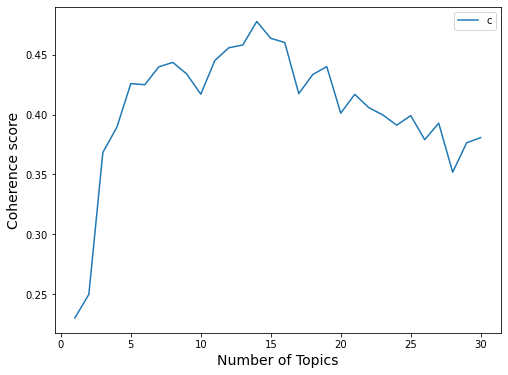

In [10]:
# Show the learning curve of the LdaMulticore model
plt.plot(n_topics, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()

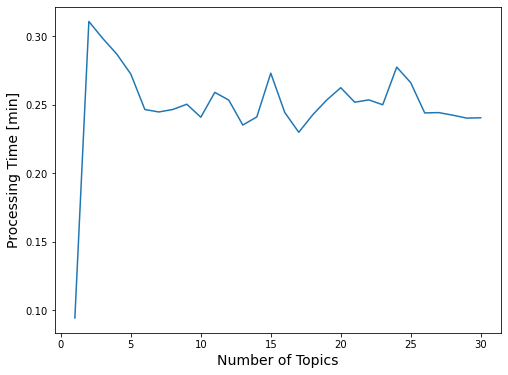

In [11]:
# Show the evolvement of the processing time 
plt.plot(n_topics, processing_times)
plt.xlabel("Number of Topics")
plt.ylabel("Processing Time [min]")
plt.show()

In [12]:
# Take a look at the resulting coherence scores
coherence_values

[0.2300386074771512,
 0.2497770817479349,
 0.36837106596216446,
 0.3894042814383134,
 0.4259020423468198,
 0.42501869382069973,
 0.43991383065159934,
 0.4436355808459159,
 0.4338844891434376,
 0.4170329654964813,
 0.4451424485229124,
 0.4558722126654158,
 0.4581674501082551,
 0.4778393357805052,
 0.4637279809225101,
 0.46026366814562647,
 0.4175328488274702,
 0.4334634237654459,
 0.44010117444698627,
 0.40122128300569243,
 0.4169275721734779,
 0.4058452189603091,
 0.3997761786594408,
 0.39117809101685014,
 0.39913662751480117,
 0.3790699683239546,
 0.39280224366115624,
 0.35186680183232694,
 0.3764741423313641,
 0.38080192103338756]

In [13]:
# Take a look at the required processing times (in minutes)
processing_times

[0.09443708658218383,
 0.3108803391456604,
 0.2983941316604614,
 0.28700756231943764,
 0.2724474231402079,
 0.2466197411219279,
 0.24481094678243,
 0.2466398596763611,
 0.250460680325826,
 0.24099088907241822,
 0.259118926525116,
 0.25346604188283284,
 0.2352825125058492,
 0.24118341207504274,
 0.2731354753176371,
 0.2444234053293864,
 0.2300067663192749,
 0.24277929862340292,
 0.25356648365656537,
 0.26253297726313274,
 0.25192325909932456,
 0.25363680919011433,
 0.25007259051005043,
 0.2775585095087687,
 0.26620769103368125,
 0.24412349065144856,
 0.24435019890467327,
 0.24247752825419108,
 0.2403382420539856,
 0.24056648810704548]

In [14]:
# Take a look at the grid of the number of topics
n_topics

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30]

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 7.2 Summarize and Visualize the Results </h2>
</div>

In [5]:
# Storage of the results for LdaMulticore model with passes = 12
coherence_values = [0.2300386074771512,  0.2497770817479349,  0.36837106596216446, 0.3894042814383134,  0.4259020423468198,
                    0.42501869382069973, 0.43991383065159934, 0.4436355808459159,  0.4338844891434376,  0.4170329654964813,
                    0.4451424485229124,  0.4558722126654158,  0.4581674501082551,  0.4778393357805052,  0.4637279809225101,
                    0.46026366814562647, 0.4175328488274702,  0.4334634237654459,  0.44010117444698627, 0.40122128300569243,
                    0.4169275721734779,  0.4058452189603091,  0.3997761786594408,  0.39117809101685014, 0.39913662751480117,
                    0.3790699683239546,  0.39280224366115624, 0.35186680183232694, 0.3764741423313641,  0.38080192103338756]
processing_times = [0.09443708658218383, 0.3108803391456604,  0.2983941316604614,  0.28700756231943764, 0.2724474231402079,
                    0.2466197411219279,  0.24481094678243,    0.2466398596763611,  0.250460680325826,   0.24099088907241822,
                    0.259118926525116,   0.25346604188283284, 0.2352825125058492,  0.24118341207504274, 0.2731354753176371,
                    0.2444234053293864,  0.2300067663192749,  0.24277929862340292, 0.25356648365656537, 0.26253297726313274,
                    0.25192325909932456, 0.25363680919011433, 0.25007259051005043, 0.2775585095087687,  0.26620769103368125,
                    0.24412349065144856, 0.24435019890467327, 0.24247752825419108, 0.2403382420539856,  0.24056648810704548]
n_topics = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

In [6]:
## Fit a logarithmic model to the resulting coherence scores to get a smooth approximation of the learning curve
# Generate the required logarithmic features on the basis of the n_topics variable
X = np.column_stack((n_topics, np.log(n_topics)))
# Set up and fit the logarithmic regression model
reg = linear_model.LinearRegression(fit_intercept = True)
reg.fit(X, coherence_values)
# Get the fitted values for a homogenous grid of 300 values between the maximum and the minimum n_topics
xnew = np.linspace(np.min(n_topics), np.max(n_topics), 300)
coherence_values_smoothed = reg.predict(np.column_stack((xnew, np.log(xnew))))

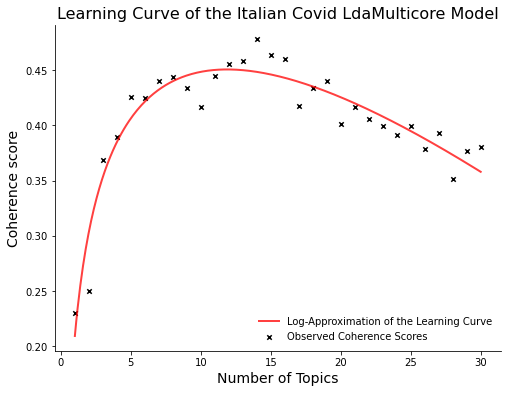

In [7]:
# Show the actual coherence scores obtained together with the smoothly approximated learning curve of the LdaMulticore model
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(n_topics, coherence_values, color = 'black', s = 20, marker = 'x', label = 'Observed Coherence Scores')
#ax.plot(n_topics, coherence_values, color = 'black', linewidth = 1.5, alpha = 0.7, linestyle = '--', label = 'True Learning Curve')
ax.plot(xnew, coherence_values_smoothed, color = 'red', linewidth = 2, alpha = 0.75, label = 'Log-Approximation of the Learning Curve')
ax.set(title = "Learning Curve of the Italian Covid LdaMulticore Model",
       xlabel = "Number of Topics",
       ylabel = "Coherence score")
ax.legend(loc = 'best', frameon = False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

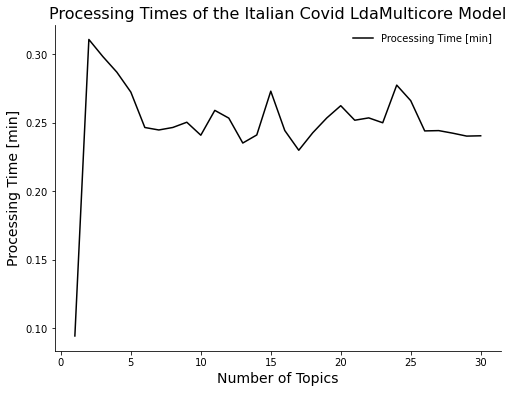

In [8]:
# Show the evolvement of the processing time
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(n_topics, processing_times, color = 'black', linewidth = 1.5, alpha = 1, linestyle = '-', label = 'Processing Time [min]')
ax.set(title = "Processing Times of the Italian Covid LdaMulticore Model",
       xlabel = "Number of Topics",
       ylabel = "Processing Time [min]")
ax.legend(loc = 'best', frameon = False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [9]:
# Get the number of topics from the topic model that exhibits the highest coherence score
opt_n_topic = n_topics[np.argmax(np.array(coherence_values))]
# Display the optimal number of topics
print('The optimal number of topics according to the coherence score is', opt_n_topic)

The optimal number of topics according to the coherence score is 14


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 7.3 Determine the optimal K </h2>
</div>

To get a starting point for finding the optimal number of topics $K^*$, we focus on two measures of the estimated models: (1) the coherence score $c(K)$ and (2) the maximal Jaccardian similarity $j(K)$ observed between the top 10 keywords of two of the resulting topics, which is defined by

$$
j(K) = max \left(\frac{|(S_i \cap S_j)|}{|(S_i \cup S_j)|}\right), \ \text{for} \ i \neq j \ \text{and} \ i,j \in \{1,\dots,K\}
$$

where $K$ corresponds to the number of topics in the model and $S_i$ is the set consisting of the top 10 keywords of the $i^{th}$ topic from the model under consideration (note: the maximal Jaccardian similarity measures the highest similarity between two of the resulting topics of a topic model). Our aim is to choose $K$ such that for the corresponding model $c(K)$ is maximized and $j(K)$ is minimized. Since both of these metrics are measured on a scale between 0 and 1, they are directly comparable to each other such that the weighted quality of a model $q_\lambda(K)$ can be measured by the following formula: 

$$
q_\lambda(K) = 2*(\lambda*c(K) - (1-\lambda)*j(K)),
$$

where $\lambda \in [0,1]$ corresponds to the weight assigned to $c(K)$, such that th weight assigned to $j(K)$ is given by $(1-\lambda)$. However, in the present study, we opt for equal weighting of both metrics (i.e. $\lambda = \frac{1}{2}$) to obtain an initial estimate for $K^*$. The topic model relying on the such revealed "optimal" number of topics, $K^*$, is then taken as the first model for the manual review. Then, if the initially selected model appears to deliver too coarse (or too granular) topics, we increase (or decreases) $K$ until a reasonable partitioning is achieved. Furthermore, topic models for which one can reasonably argue that the number of topics is probably too small (e.g. in the context of newspaper articles this would be the case if $K$ is smaller than the number of topics by which most established news outlets sort their articles) are not considered while choosing the opitmal $K$ by means of the approach described above.

In [10]:
# Retrieve the results of the potentially optimal topic models
coherence_values = [0.4259020423468198,
                    0.42501869382069973, 0.43991383065159934, 0.4436355808459159,  0.4338844891434376,  0.4170329654964813,
                    0.4451424485229124,  0.4558722126654158,  0.4581674501082551,  0.4778393357805052,  0.4637279809225101,
                    0.46026366814562647, 0.4175328488274702,  0.4334634237654459,  0.44010117444698627, 0.40122128300569243,
                    0.4169275721734779,  0.4058452189603091,  0.3997761786594408,  0.39117809101685014, 0.39913662751480117,
                    0.3790699683239546,  0.39280224366115624, 0.35186680183232694, 0.3764741423313641,  0.38080192103338756]
processing_times = [0.2724474231402079,
                    0.2466197411219279,  0.24481094678243,    0.2466398596763611,  0.250460680325826,   0.24099088907241822,
                    0.259118926525116,   0.25346604188283284, 0.2352825125058492,  0.24118341207504274, 0.2731354753176371,
                    0.2444234053293864,  0.2300067663192749,  0.24277929862340292, 0.25356648365656537, 0.26253297726313274,
                    0.25192325909932456, 0.25363680919011433, 0.25007259051005043, 0.2775585095087687,  0.26620769103368125,
                    0.24412349065144856, 0.24435019890467327, 0.24247752825419108, 0.2403382420539856,  0.24056648810704548]
n_topics = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

In [11]:
# Define the number of top keywords to use while calculating the Jaccardian similarities between topics
num_keywords = 10

# Create a dictionary to store the LDA models
LDA_models = {}

# Create a dictionary to store the top keywords for each topic of the LDA models
LDA_topics = {}

In [12]:
# Load all desired models and extract the corresponding top keywords for their topics
for i in n_topics:
    # Load the model and store it into the LDA_models dictionary
    LDA_models[i] = gensim.models.ldamodel.LdaModel.load("LDA/Covid/it_lda_model_"+str(i)+"_topics")
    # Extract the num_keywords top keywords for each topic from the model with i topics and store them accordingly in the LDA_topics dictionary
    shown_topics = LDA_models[i].show_topics(num_topics = i, 
                                              num_words = num_keywords,
                                              formatted = False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

In [13]:
# Create a function to calculate the Jaccard similarity of two topics
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = |(A ∩ B)| / |(A ∪ B)|
    - For LDA, the Goal is a low maximal Jaccard score between the topics of a model
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [14]:
## Apply the above defined function to derive the maximal Jaccardian similarity between the top words of the resulting topics for each model
# Create storage to save the maximal topic similarity for each model
max_topic_similarities = []
# Set up a loop to iterate through all models
for model in n_topics:
    # Create storage to save the topic similarities of all possible topic pairs
    topic_similarities = []
    # Get the topics of the current model
    topics = LDA_topics[model]
    # Set up a loop to calculate the topic similarity for all possible topic pairs
    for i in range(model):
        # Set the maximal topic similarity to 0 for the baseline model, which contains only 1 topic
        if model == 1:
            topic_similarities.append(0)
        # Calculate the topic similarity for all possible topic pairs otherwise
        elif i+1 < model:
            for j in range(i+1,model):
                topic_similarities.append(jaccard_similarity(topics[i], topics[j]))
    # Get the maximal topic similarity of the model and store it within the max_topic_similarities variable
    max_topic_similarities.append(np.max(topic_similarities))

# Take a look at the result
#max_topic_similarities

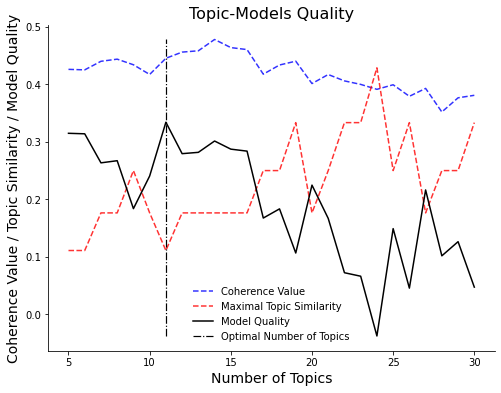

In [15]:
# Calculate the qualities of the models
qualities = np.array(coherence_values) - np.array(max_topic_similarities)

# Calculate the optimal number of topics
opt_n_topic = n_topics[np.argmax(np.array(qualities))]

# Show the development of the coherence scores, the maximal Jaccardian similarities and the model qualities
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(n_topics, coherence_values, color = 'blue', linewidth = 1.5, alpha = 0.8, linestyle = '--', label = 'Coherence Value')
ax.plot(n_topics, max_topic_similarities, color = 'red', linewidth = 1.5, alpha = 0.8, linestyle = '--', label = 'Maximal Topic Similarity')
ax.plot(n_topics, qualities, color = 'black', linewidth = 1.5, alpha = 1, label = 'Model Quality')
ax.plot(np.repeat(opt_n_topic,2), [np.min(qualities), np.max(coherence_values)], 
        color = 'black', linewidth = 1.2, alpha = 1, linestyle = '-.', label = 'Optimal Number of Topics')
ax.set(title = "Topic-Models Quality",
       xlabel = "Number of Topics",
       ylabel = "Coherence Value / Topic Similarity / Model Quality")
ax.legend(loc = 'best', frameon = False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [16]:
# Display the optimal number of topics
print('The optimal number of topics is', opt_n_topic)

The optimal number of topics is 11


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 8. Inspect the optimal LDA topic model </h2>
</div>

Since manual inspection of the topic model with 11 topics reveals that this model still yields rather coarse topics, we decide to increase $K$ until the corresponding model exhibits reasonably partitioned topics. For the Italian articles, this strategy leads us to an optimal choice of $K^* = 14$ for the COVID specific LDA model.

In [5]:
# Load the optimal model from disk and print the topics (adjust the digit appropriately!!!)
opt_n_topic = 14  # adjust the digit accordingly to load the desired model
optimal_model = gensim.models.ldamodel.LdaModel.load("LDA/Covid/it_lda_model_"+str(opt_n_topic)+"_topics")         
model_topics = optimal_model.show_topics(num_topics = opt_n_topic, num_words = 10, formatted = False)
pprint(optimal_model.print_topics(num_topics = opt_n_topic, num_words = 10))

[(0,
  '0.019*"frontaliere" + 0.010*"settore" + 0.009*"francia" + 0.009*"aumentare" '
  '+ 0.009*"personale" + 0.008*"ch" + 0.008*"calere" + 0.008*"lavoratore" + '
  '0.008*"swissinfo" + 0.007*"cantone"'),
 (1,
  '0.032*"franco" + 0.027*"banca" + 0.010*"contare" + 0.009*"interesse" + '
  '0.009*"finanziario" + 0.008*"aumentare" + 0.008*"tasso" + 0.008*"denaro" + '
  '0.008*"tassare" + 0.007*"premio"'),
 (2,
  '0.038*"mascherina" + 0.013*"aereo" + 0.011*"volo" + 0.011*"produrre" + '
  '0.008*"swiss" + 0.008*"disinfettare" + 0.007*"mano" + 0.007*"compagnia" + '
  '0.007*"volare" + 0.007*"zurigo"'),
 (3,
  '0.013*"crisi" + 0.009*"settore" + 0.007*"economico" + 0.007*"azienda" + '
  '0.006*"economia" + 0.006*"attività" + 0.005*"franco" + 0.005*"finanziario" '
  '+ 0.005*"politico" + 0.005*"cantone"'),
 (4,
  '0.012*"club" + 0.010*"sport" + 0.010*"stagione" + 0.009*"lugano" + '
  '0.008*"prossimo" + 0.008*"evento" + 0.008*"decisione" + 0.007*"campionare" '
  '+ 0.007*"keystone" + 0.007*"hoc

In [6]:
# Read in the preprocessed data of the Covid articles
articles = pd.read_csv("Analysis/articles_main.csv", index_col = 0, usecols = [0,11,12,13,14,15,16])
Covid_idx = articles.loc[np.logical_or(articles['Topic_1'] == 'COVID', 
                                       np.logical_and(articles['Topic_2'] == 'COVID', 
                                                      articles['Affiliation_Prob_2'] >= 0.25))].index
del articles
it_tx, it_idx = read_preprocessed('it')
location = it_idx[it_idx.it_idx.isin(Covid_idx)].index.tolist()
it_tx = itemgetter(*location)(it_tx)
it_idx = it_idx.iloc[location]
it_idx.set_index(np.arange(it_idx.shape[0]), inplace = True)

In [7]:
# Create the corpus again
corpus = [optimal_model.id2word.doc2bow(article) for article in it_tx]

In [8]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, optimal_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.072598  0.014939       1        1  22.520045
10     0.065359 -0.018804       2        1  11.532353
13    -0.023746 -0.086762       3        1   9.150676
11     0.043513 -0.002301       4        1   8.115922
5      0.042429  0.033904       5        1   7.519205
1     -0.111195 -0.040670       6        1   6.669830
9      0.009711  0.115474       7        1   6.612406
6     -0.015416  0.062449       8        1   5.568592
8     -0.024209 -0.074481       9        1   5.003694
12     0.182656 -0.039836      10        1   4.302374
7     -0.025116 -0.008507      11        1   4.233162
4     -0.020664  0.065367      12        1   4.076545
2     -0.016574  0.007673      13        1   2.667850
0     -0.034150 -0.028444      14        1   2.027346, topic_info=            Term        Freq       Total Category  logprob  loglift
569   mascherina  741.000000  741.000000  Default  30.0000  30.0000
283       franco  891.000000  891.000000  Default  29.0000  29.0000
1074       banca  446.000000  446.000000  Default  28.0000  28.0000
560      decesso  483.000000  483.000000  Default  27.0000  27.0000
628       scuola  472.000000  472.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
148     ospedale   20.241887  727.453962  Topic14  -5.3700   0.3166
263        crisi   19.864639  880.471541  Topic14  -5.3888   0.1069
11      paziente   16.924033  829.389761  Topic14  -5.5490   0.0065
155    periodare   15.080983  490.893504  Topic14  -5.6643   0.4157
415     italiano   14.706247  404.957552  Topic14  -5.6895   0.5829

[752 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1102      1  0.124319  abitare
1102      2  0.438773  abitare
1102      3  0.051190  abitare
1102      4  0.080442  abitare
1102      5  0.014626  abitare
...     ...       ...      ...
232      10  0.018387   zurigo
232      11  0.082742   zurigo
232      12  0.027581   zurigo
232      13  0.094234   zurigo
232      14  0.029879   zurigo

[7258 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 11, 14, 12, 6, 2, 10, 7, 9, 13, 8, 5, 3, 1])

In [9]:
# Delete unnecessary variables
del it_tx

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 9. Find the most likely topic for each document </h2>
</div>

In [10]:
# Define a function to retrieve the topic id of the most likely topic assignment for each article together with the according topic affiliation probability
def get_article_topics(ldamodel, corpus, second_most = False):
    # Create storage to save the id of the assigned topics and the according topic affiliation probabilities
    assigned_topics = []
    affiliation_probs = []
    # Keep track of the processing time
    t = time.time()
    # Get the most dominant topic for each document
    for topic_dist_tuples in ldamodel.get_document_topics(corpus):
        # Get a tuple containing the topic id of the second most dominant topic together with the according topic affiliation probability if second_most = True
        if second_most:
            try:
                topic_prob_tuple = sorted(topic_dist_tuples, key = lambda tup: tup[1], reverse = True)[1]
            # If the affiliation probability of the second topic is below 0.01, then the topic is ignored and we therefore returen a tuple of NAs
            except:
                topic_prob_tuple = (np.nan, np.nan)
        # Get a tuple containing the topic id of the most dominant topic together with the according topic affiliation probability otherwise
        else:
            topic_prob_tuple = sorted(topic_dist_tuples, key = lambda tup: tup[1], reverse = True)[0]
        # Extract the topic id of the most dominant topic
        assigned_topics.append(topic_prob_tuple[0])
        # Extract the according topic affiliation probability
        affiliation_probs.append(topic_prob_tuple[1])
    # Print out the processing time
    if second_most:
        print("Processing time to retrieve the second most dominant topic for each article:", str((time.time() - t)/60), "minutes")
    else:
        print("Processing time to retrieve the most dominant topic for each article:", str((time.time() - t)/60), "minutes")
    
    # Return the results
    return assigned_topics, affiliation_probs

In [11]:
# Apply the above defined function to get the most likely topic assignments together with the according topic affiliation probabilities
assigned_topic_1, affiliation_prob_1 = get_article_topics(optimal_model, corpus, second_most = False)

Processing time to retrieve the most dominant topic for each article: 0.034240404764811196 minutes


In [12]:
# Apply the above defined function to get the second most likely topic assignments together with the according topic affiliation probabilities
assigned_topic_2, affiliation_prob_2 = get_article_topics(optimal_model, corpus, second_most = True)

Processing time to retrieve the second most dominant topic for each article: 0.03134998877843221 minutes


In [13]:
# Create a correctly indexed dataframe containing the topic assignment and the according topic affiliation probability
topic_df = pd.DataFrame(assigned_topic_1, index = it_idx.it_idx.values.tolist(), columns = ['Topic_ID_1'])
topic_df['Affiliation_Prob_1'] = affiliation_prob_1
topic_df['Topic_ID_2'] = assigned_topic_2
topic_df['Affiliation_Prob_2'] = affiliation_prob_2
# Save the results to a csv file
topic_df.to_csv("LDA/Covid/Topic_Assignment/it_topic_assignment.csv", index = True)

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 10. Get the most representative articles for each topic (preparation) </h2>
</div>

In [5]:
# Load the optimal model from disk and save the topics' keywords
opt_n_topic = 14  # adjust the digit accordingly to load the desired model
optimal_model = gensim.models.ldamodel.LdaModel.load("LDA/Covid/it_lda_model_"+str(opt_n_topic)+"_topics")         
model_topics = optimal_model.show_topics(num_topics = opt_n_topic, num_words = 20, formatted = False)

In [6]:
# Read in the Dataframe containing the topic assignments
topic_df = pd.read_csv("LDA/Covid/Topic_Assignment/it_topic_assignment.csv", index_col = 0, dtype = {'Topic_ID_1': int, 'Affiliation_Prob_1': float, 'Topic_ID_2': float, 'Affiliation_Prob_2': float})

In [7]:
# Read in the preprocessed fulltext data of the Covid articles
articles = pd.read_csv("Analysis/articles_main.csv", index_col = 0, usecols = [0,11,12,13,14,15,16])
Covid_idx = articles.loc[np.logical_or(articles['Topic_1'] == 'COVID', 
                                       np.logical_and(articles['Topic_2'] == 'COVID', 
                                                      articles['Affiliation_Prob_2'] >= 0.25))].index
del articles
it_tx_fulltext, it_idx = read_preprocessed_fulltext('it')
location = it_idx[it_idx.it_idx.isin(Covid_idx)].index.tolist()
it_tx_fulltext = itemgetter(*location)(it_tx_fulltext)
it_idx = it_idx.iloc[location]
it_idx.set_index(np.arange(it_idx.shape[0]), inplace = True)

In [8]:
# Define a function to display the most representative articles for each topic
def get_representative_articles(fulltext_data, index_df, topic_assignment_df, topic_id, n_top_articles = 5, show_n_last_elements = None):
    # Define the variable show_n_last_elements appropriatly if it is not defined
    if show_n_last_elements == None:
        show_n_last_elements = n_top_articles
    # Get the index of the most representative articles for the focal topic
    article_ids = topic_assignment_df.loc[topic_assignment_df['Topic_ID_1'] == topic_id].sort_values(by = ['Affiliation_Prob_1'], ascending = False)[:n_top_articles].index
    # Get the location of theses articles in the list of fulltexts
    location = []
    for article_id in article_ids:
        location.append(index_df.loc[index_df.iloc[:,0] == article_id].index[0])
    # Print out the identified articles
    return list(fulltext_data[i] for i in location)[(n_top_articles-show_n_last_elements):]

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 10.1 Display most representative articles for each topic </h2>
</div>

In [9]:
## Topic 0
# Define the id of the topic of interest
id_focal_topic = 0
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 4)

(0,
 [('frontaliere', 0.019314934),
  ('settore', 0.010168489),
  ('francia', 0.009105314),
  ('aumentare', 0.009019758),
  ('personale', 0.008512755),
  ('ch', 0.008376194),
  ('calere', 0.008330741),
  ('lavoratore', 0.007987461),
  ('swissinfo', 0.00784887),
  ('cantone', 0.0069757383),
  ('italia', 0.006415527),
  ('trimestre', 0.0060276263),
  ('registrare', 0.005241166),
  ('mercato', 0.005159222),
  ('germania', 0.0051376866),
  ('regione', 0.0050935172),
  ('azienda', 0.0050247237),
  ('ospedale', 0.004654072),
  ('crisi', 0.0045673344),
  ('tedesco', 0.004375491)])


[' Gli apparecchi per la respirazione sono fra i prodotti che possono rivelarsi decisivi per la sopravvivenza di migliaia di persone. Leader globale del settore è l\'azienda svizzera Hamilton. L\'azienda fa di tutto per rispondere alle urgenze, afferma il suo amministratore delegato. Peter SiegenthalerL\'azienda medica Hamilton Bonaduz AG, con sede nel canton Grigioni, produce macchine per la respirazione utilizzati nei reparti di cure intense degli ospedali. La più recente generazione di respiratori era molto richiesta in tutto il mondo già prima dell\'inizio della pandemia di coronavirus. Ora la domanda è letteralmente esplosa. Sebbene l\'azienda grigionese faccia di tutto per aumentare le capacità produttive, non può coprire il fabbisogno di tutti, afferma l\'amministratore delegato Andreas Wieland a colloquio con swissinfo. ch. swissinfo. ch: Quanto è aumentata la domanda a causa del coronavirus?Andrea Wieland: Già prima della pandemia la nostra azienda era molto cresciuta. L\'anno

In [10]:
# Further highly ranked articles of topic 0
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 10, show_n_last_elements = 5)

[' NEUCHÂTEL. Mancano ancora i dati di alcuni cantoni, ma si delinea un anno in linea con quelli precedenti. In Ticino registrati 282 casi. Nel 2019 sono state registrate 9 182 interruzioni di gravidanza di donne domiciliate in Svizzera (di cui 282 in Ticino). Sono i numeri rilasciati dall’Ust, che al momento dell’elaborazione, tuttavia, non disponeva ancora di tutti i dati dei Cantoni a causa della situazione straordinaria (mancano circa 1 000 interruzioni). Per i Cantoni che hanno comunicato le cifre, ciò corrisponde a un tasso di 6,5 interruzioni di gravidanza ogni 1000 donne di età compresa tra 15 e 44 anni. Dopo il continuo calo osservato dal 2010, dal 2017 il tasso torna a segnare un leggero rialzo, passando da 6,2 a 6,5 interruzioni ogni 1000 donne. I dati hanno registrato un netto calo tra il 2007 e il 2015 per le donne tra i 15 e i 19 anni. Dal 2015 il tasso si mantiene con una relativa costanza a un livello basso, nonostante il leggero aumento da 3,3 a 3,5 interruzioni di gra

In [11]:
## Topic 1
# Define the id of the topic of interest
id_focal_topic = 1
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 2)

(1,
 [('franco', 0.031845372),
  ('banca', 0.027342096),
  ('contare', 0.009905055),
  ('interesse', 0.00928286),
  ('finanziario', 0.008576852),
  ('aumentare', 0.008421239),
  ('tasso', 0.008325738),
  ('denaro', 0.008192865),
  ('tassare', 0.0075398837),
  ('premio', 0.0066779973),
  ('euro', 0.0065975976),
  ('pagamento', 0.006498728),
  ('bancario', 0.006481308),
  ('costo', 0.0058584227),
  ('spesa', 0.0056314375),
  ('basso', 0.005561231),
  ('negativo', 0.00543339),
  ('credito', 0.005416852),
  ('assicurazione', 0.005261147),
  ('economia', 0.0051141554)])


[" Introdotti cinque anni fa dalla Banca nazionale svizzera (BNS), i tassi d’interesse negativi hanno ripercussioni sempre più importanti a livello economico e sociale. Nonostante le critiche, la banca centrale non vuole rinunciare a questa misura, considerata indispensabile per contrastare un eccessivo apprezzamento del franco. Armando MombelliPerché la BNS ha introdotto tassi d’interesse negativi?In seguito alla crisi finanziaria internazionale scoppiata nel 2008, numerose banche centrali hanno adottato una serie di misure, senza precedenti, per tenere in piedi il settore bancario e scongiurare il rischio di una depressione economica. Tra queste misure vi sono stati tagli di portata storica dei tassi d’interesse: negli Stati uniti e nella zona euro sono scesi alcuni anni fa quasi a livello zero. Dato che in tempo di crisi il franco assume regolarmente un ruolo di valore rifugio, la BNS è stata costretta ad andare addirittura al di sotto dello zero. Cinque anni fa, la banca centrale e

In [12]:
# Further highly ranked articles of topic 1
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 20, show_n_last_elements = 5)

[' LUGANO. Un miliardo di franchi. A tanto ammonta il volume dei crediti Covid 19 finora richiesti dalle imprese ticinesi per far fronte alla pandemia di coronavirus. Si tratta di una cifra considerevole rapportata all’economia del nostro cantone, commenta l’Associazione bancaria ticinese che rileva regolarmente questi dati. L’Associazione precisa che ci sono state 8 430 richieste per crediti sotto il mezzo milione, mentre 42 erano per cifre superiori. ',
 ' La differenza tra i salari più alti e quelli più bassi nei grandi gruppi elvetici rimane abissale: lo denuncia il sindacato Unia, che martedì ha pubblicato il suo studio annuale sulla forbice salariale. Per il suostudioLink esterno, il sindacato ha analizzato le retribuzioni delle 36 principali imprese svizzere nel 2018. La forbice salariale rileva Unia si è ridotta leggermente, scendendo a un rapporto di 1 a 134, rispetto all\'1 a 137 dell\'anno prima. La discrepanza maggiore di 1 a 267 la si ritrova tra le buste paga di Ubs, dire

In [13]:
## Topic 2
# Define the id of the topic of interest
id_focal_topic = 2
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(2,
 [('mascherina', 0.037814897),
  ('aereo', 0.012955563),
  ('volo', 0.010644181),
  ('produrre', 0.010603676),
  ('swiss', 0.007743805),
  ('disinfettare', 0.0077248923),
  ('mano', 0.007496267),
  ('compagnia', 0.0072340225),
  ('volare', 0.0071814046),
  ('zurigo', 0.0070996317),
  ('protezione', 0.006620673),
  ('passeggero', 0.0060662874),
  ('usare', 0.0058179908),
  ('prezzo', 0.0049048136),
  ('franco', 0.004896231),
  ('igienico', 0.0048143594),
  ('affermare', 0.0047415),
  ('coop', 0.004733319),
  ('aeroporto', 0.0046224375),
  ('sicurezza', 0.0042519686)])


[' SAVOSA. Il medico Anna Sekulovski produce protezioni facciali esclusive per i suoi pazienti. Colori variopinti e disegni divertenti servono anche a incentivarne l’utilizzo. Anna Sekulovski, di Lugano e medico dentista dal 2000, è da sempre confrontata con la mascherina a causa della sua professione. Durante la quarantena, oltre a curare i casi urgenti, ha voluto dedicarsi al suo hobby di lavoro manuale, ispirata dalle richieste delle nipotine. L’obbligo di proteggersi il volto sottolinea la professionista ticinese lasciava spazio anche alla fantasia e ho pensato soprattutto ai bambini, il cui sorriso è di aiuto a tutti. Ho creato alcuni modelli di fantasia che sono piaciuti subito e alla fine ho ricevuto diverse ordinazioni anche dagli adulti. La dentista di Savosa, che ha usato materiale rigorosamente svizzero, ha prodotto quasi 200 mascherine, tutte fatte a mano, in cui ha creato uno spazio per inserire un filtro supplementare. Non avrei mai creduto in una simile richiesta e penso

In [14]:
## Topic 3
# Define the id of the topic of interest
id_focal_topic = 3
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 2)

(3,
 [('crisi', 0.0128178615),
  ('settore', 0.00915476),
  ('economico', 0.007249325),
  ('azienda', 0.006984963),
  ('economia', 0.0058430335),
  ('attività', 0.005501134),
  ('franco', 0.005442943),
  ('finanziario', 0.0053069745),
  ('politico', 0.0051019327),
  ('cantone', 0.0046289177),
  ('estero', 0.004455487),
  ('confederazione', 0.004381734),
  ('dipendere', 0.004331809),
  ('aiutare', 0.0042030807),
  ('grande', 0.0041429144),
  ('società', 0.004142873),
  ('emergenza', 0.0039062325),
  ('ridurre', 0.0038085796),
  ('piccolo', 0.0036662521),
  ('livellare', 0.0034811057)])


[' Adottata con successo nel 2009, dopo la crisi finanziaria, la disoccupazione parziale è al centro da una settimana di un rinnovato interesse, in concomitanza con la diffusione del coronavirus in Svizzera. Nell\'Arco giurassiano, patria dell\'orologeria swiss made, si pensa di rispondere così agli effetti economici del virus. Alain MeyerDa Grenchen, nel canton Soletta, a Saignelégier, nelle Franche Montagnes giurassiane, terre in cui da lungo tempo si è annidata l\'industria orologiera svizzera, si sta riflettendo se avviare le procedure burocratiche, piuttosto lunghe e fastidiose, per poter ricorrere alla disoccupazione parziale. + La disoccupazione parziale, un\'arma anti crisi efficaceObiettivo: contrastare nel più breve tempo possibile gli effetti devastanti del coronavirus sull\'economia regionale. Se varie aziende orologiere stanno pensando seriamente di farvi ricorso, nessuna osa ancora ammetterlo apertamente. Non solo devono reagire al crollo della domanda proveniente dalla C

In [15]:
# Further highly ranked articles of topic 3
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 18, show_n_last_elements = 3)

[' LUGANO. Dipendenti quasi dimezzati a Lugano. Fatturato in forte calo. Ma l’enfant terrible della Fashion Valley non piega la testa. La pizza in ufficio. Il sushi. Le riunioni fino a notte fonda, e le liti con i sindacati. Una cosa è certa: Philipp Plein ha reso il Ticino un posto meno noioso. Con il suo seguito di frontalieri e businessman (persino Berlusconi) e la sua Ferrari verde, per cui è finito a litigare anche con la casa di Maranello. Negli ultimi mesi lo stilista ha dovuto fare due cose che probabilmente non gli piacciono: fermarsi, e ridimensionarsi. I primi licenziamenti a Lugano sette risalgono a marzo. Ma era solo l’inizio: con la pandemia il marchio ha ridotto i dipendenti sul Ceresio da 110 a 79. A confermarlo a tio/20minuti è lo stesso imprenditore. Non è stato bello né facile racconta in un’intervista esclusiva (il testo completo su tio. ch). La crisi attuale ha colpito il nostro settore in modo pesante. Ho dovuto prendere decisioni difficili. Non è nuovo a queste s

In [16]:
## Topic 4
# Define the id of the topic of interest
id_focal_topic = 4
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 2)

(4,
 [('club', 0.011912126),
  ('sport', 0.010319222),
  ('stagione', 0.010276914),
  ('lugano', 0.008784499),
  ('prossimo', 0.0083181495),
  ('evento', 0.008297539),
  ('decisione', 0.008115552),
  ('campionare', 0.0068339715),
  ('keystone', 0.0067366776),
  ('hockey', 0.0065964614),
  ('league', 0.0061828),
  ('partito', 0.0061597535),
  ('grande', 0.005839912),
  ('marzo', 0.00569158),
  ('sportivo', 0.0052237497),
  ('emergenza', 0.0051203887),
  ('presidente', 0.0050493195),
  ('società', 0.0049742702),
  ('calciare', 0.004891387),
  ('quarantena', 0.0048644613)])


[' BERNA. Il campionato almeno per ora va avanti: stasera scendono in pista anche Ambrì e Lugano. Nel frattempo i presidenti dei 12 club hanno scritto una lettera aperta: Lasciateci continuare. Inutile negarlo, quelli che stiamo vivendo sono giorni intensi e di preoccupazione per tutto il mondo dello sport, col destino del campionato di hockey ancora da definire. La scorsa settimana la SIHF ha precisato che si andrà avanti almeno sino al 2 novembre indipendentemente dal numero di spettatori in alcuni Cantoni c’è già stata una riduzione a 1000, in altri a zero e la situazione resta costantemente monitorata. In questo scenario d’incertezza per ora si va avanti, e questa sera sono 5 i match in programma: in pista anche le ticinesi, con l’Ambrì che ospita lo Zurigo e il Lugano che fa visita al Losanna. Tornata a giocare e vincere dopo lo stop per la quarantena, la squadra di Pelletier cercherà innanzitutto conferme. I biancoblù in campionato sono invece reduci da quattro sconfitte, tutte d

In [17]:
# Further highly ranked articles of topic 4
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 10, show_n_last_elements = 3)

[' LUGANO. Finito nelle grinfie della pandemia e congelato ormai da inizio marzo, anche il calcio elvetico potrebbe pian piano tornare a rivedere la luce. Tra le misure di allentamento annunciate ieri dal Consiglio federale, vi è infatti anche quella che prevede una graduale ripresa delle attività sportive. In particolare, nello sport d’élite, dall’11 maggio saranno permesse sedute collettive. Da lunedì 8 giugno potranno riprendere anche le partite. Una buona notizia, ma anche uno scenario che lascia degli interrogativi. L’evolversi della situazione resta infatti da monitorare con cautela, anche per evitare brutte sorprese o bruschi dietrofront. Il Consiglio federale dà questa possibilità, ma la palla adesso è passata alla Swiss Football League interviene Angelo Renzetti, presidente del Lugano Sarà la SFL, composta dalle squadre, a decidere i prossimi passi. Io, ultimamente, ho visto molta negatività attorno all’ipotesi di ripartire. A giusta ragione ho ancora i miei dubbi che si ricom

In [18]:
## Topic 5
# Define the id of the topic of interest
id_focal_topic = 5
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(5,
 [('test', 0.014166446),
  ('medicare', 0.0139402235),
  ('lugano', 0.00868708),
  ('app', 0.0077656195),
  ('quarantena', 0.0076544695),
  ('sintomo', 0.0075781457),
  ('contattare', 0.007271929),
  ('tampone', 0.00712407),
  ('contatto', 0.006162145),
  ('distanza', 0.0051827673),
  ('servizio', 0.005170972),
  ('risultare', 0.0051011853),
  ('contagiare', 0.005015941),
  ('persona', 0.0049306485),
  ('mascherina', 0.0046517635),
  ('protezione', 0.0046277666),
  ('isolamento', 0.0045211585),
  ('ufficio', 0.0044017253),
  ('problema', 0.004356582),
  ('informazione', 0.0042457455)])


[" La Svizzera sarà tra i primi paesi europei a introdurre, entro fine giugno, un’app per smartphone in grado di tracciare i contatti ravvicinati con persone che hanno contratto il SARS CoV 2. Il parlamento ha approvato le basi legali dell’applicazione SwissCovid, concepita in modo da tutelare la privacy degli utenti. L’epidemia di coronavirus è stata arginata con successo nel giro di alcuni mesi in Svizzera: oggi si contano da una decina a una ventina di contagi accertati al giorno, contro gli oltre mille che si registravano in marzo. La graduale soppressione delle misure di contenimento e la prossima riapertura delle frontiere potrebbero però favorire una nuova diffusione del virus. L’app SwissCovid potrebbe quindi rappresentare uno strumento importante per ridurre i rischi di una seconda ondata di SARS CoV 2: grazie al calo dei casi di infezione si possono ricostruire più facilmente le catene di trasmissione e limitare ulteriori contagi. Dopo la Camera dei Cantoni, lunedì sera anche

In [19]:
## Topic 6
# Define the id of the topic of interest
id_focal_topic = 6
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 4)

(6,
 [('dipendere', 0.015640989),
  ('italia', 0.01333965),
  ('italiano', 0.011527603),
  ('azienda', 0.009256391),
  ('pubblico', 0.007932596),
  ('frontiera', 0.007001535),
  ('giugno', 0.006755149),
  ('previsto', 0.0053542517),
  ('lavoratore', 0.005292401),
  ('comunicazione', 0.0048195324),
  ('maggio', 0.0048174164),
  ('decisione', 0.004272209),
  ('necessario', 0.0042583193),
  ('autorità', 0.004132828),
  ('leggere', 0.0039853156),
  ('salute', 0.0038774344),
  ('confederazione', 0.0037930883),
  ('manifestazione', 0.0037710273),
  ('prossimo', 0.0037576412),
  ('regione', 0.003720433)])


[' Attraversare i valichi doganali italo svizzeri, che in questo periodo di pandemia sono stati sigillati, è un\'impresa. Berna consente l\'accesso ai frontalieri e ai familiari stretti, Roma lo limita anche agli italiani (e stranieri) residenti se non c\'è un\'""urgenza assoluta"". Leonardo SpagnoliCon i primi allentamenti dei lockdown, seguiti all\'arretramento del numero dei contagi del nuovo coronavirus, i cittadini hanno iniziato a potersi muovere. In Italia da lunedì 4 maggio hanno ripreso le attività produttive e sono consentiti, a determinate condizioni, gli spostamenti anche al di fuori del proprio comune di residenza ma per il momento, salvo alcuni casi tassativi, sempre all\'interno della stessa regione. In Svizzera dove la prima tappa della fase 2 è partita il 27 aprile (il 4 maggio in Ticino) sono sempre stati consentiti gli spostamenti interni: restano vietati invece, almeno fino all\'8 giugno, gli assembramenti di oltre cinque persone. Questi primi allentamenti però non 

In [20]:
# Further highly ranked articles of topic 6
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 15, show_n_last_elements = 2)

[' CHIASSO. Attività chiuse, home office e limitazione degli spostamenti: alla frontiera ticinese con l’Italia il traffico è calato, rispetto allo scorso mese, di oltre il 70. Da qui la decisione dell’Amministrazione federale delle dogane di chiudere, da ieri alle 23, altri tre valichi. Si tratta di Brusata e Dirinella (chiusura totale) e Gandria (chiusura dalle 20 alle 5). In questo modo il traffico viene ulteriormente concentrato nelle principali dogane (restano aperti cinque valichi). Per quanto riguarda il traffico delle persone, restano valide le restrizioni relative all’entrata. Lo svolgimento del traffico merci non subirà restrizioni. ',
 ' MILANO. Per contrastare il forte aumento dei contagi (oltre 4000 nella giornata di ieri, di cui 1858 a Milano) la Lombardia sceglie la via del coprifuoco. Dalle 23 alle 5 del mattino saranno consentiti solo spostamenti motivati da comprovate esigenze lavorative o da situazioni di necessità e urgenza. La misura, attiva da oggi, resterà in vigo

In [21]:
## Topic 7
# Define the id of the topic of interest
id_focal_topic = 7
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 2)

(7,
 [('scuola', 0.028899252),
  ('bambino', 0.025331287),
  ('donna', 0.008775051),
  ('genitore', 0.008400516),
  ('età', 0.0076512466),
  ('classe', 0.0075085927),
  ('famiglia', 0.0065946304),
  ('studiare', 0.006560201),
  ('scolastico', 0.0063017514),
  ('allievo', 0.0062856786),
  ('docente', 0.005977266),
  ('giovane', 0.005831205),
  ('distanza', 0.00581695),
  ('medio', 0.0057034665),
  ('studente', 0.005621528),
  ('problema', 0.0051141623),
  ('attività', 0.0047941674),
  ('adulto', 0.0047176084),
  ('istituto', 0.004717485),
  ('uomini', 0.0045442125)])


[' Migliaia di bambini sono tornati in classe lunedì in Svizzera, dove le scuole obbligatorie sono state riaperte dopo due mesi di lockdown per il coronavirus. Ma sentimenti e approcci cantonali sono contrastanti. Isobel Leybold Johnson""Sono davvero molto contento di tornare a scuola perché ne ho abbastanza delle lezioni a casa"", ha detto la settimana scorsa Emile, 7 anni, di Ginevra, al quotidianoLe Temps. ""Ho visto un solo compagno durante il confinamento, quindi non vedo l\'ora di ritrovarmi con tutta la classe"". Ma altri alunni non ne sono così entusiasti. ""Non ho più tanta voglia di tornare a scuola. Mi piace il confinamento, poiché ci si può alzare quando si vuole e avere l\'orario che si preferisce. Trovo inoltre i compiti più facili"", ha detto allo stesso giornale, Nina, dieci anni, di Friburgo. Lunedì 11 maggio, le scuole obbligatorie (con allievi fino a 16 anni) hanno ricominciato le lezioni in classe, almeno parzialmente. Nel sistema federale svizzero, l\'istruzione co

In [22]:
# Further highly ranked articles of topic 7
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 10, show_n_last_elements = 3)

[' ZURIGO. Si parla di allusioni verbali, ma anche di soprusi più gravi. I risultati preoccupanti di un sondaggio condotto dall’Unia. Si va dalle allusioni verbali e dal contatto fisico fino allo stupro: un apprendista su tre è già stato vittima di molestie sessuali sul posto di lavoro. Lo si evince da un sondaggio condotto dall’Unia, che mostra quanto è diffuso il fenomeno. I risultati sono scioccanti dice Kathrin Ziltener, segretaria nazionale dei Giovani Unia, a 20 Minuten. Le cifre sono particolarmente inquietanti poiché gli apprendisti sono entrati da poco nel mondo del lavoro e sono in gran parte ancora minorenni, spiega ancora Ziltener. Per gli ottocento giovani che hanno preso parte al sondaggio non rappresentativo si parla infatti di un’età media di diciannove anni. Il 36 delle donne ha indicato di aver già subito molestie sessuali. Per gli uomini la percentuale è invece del 25. Le molestie risultano essere soprattutto verbali. Duecento degli intervistati parlano infatti di al

In [23]:
## Topic 8
# Define the id of the topic of interest
id_focal_topic = 8
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 2)

(8,
 [('vaccinare', 0.023617428),
  ('oms', 0.012869358),
  ('sviluppare', 0.009079796),
  ('vaccinazione', 0.009064533),
  ('vaccino', 0.008936905),
  ('dose', 0.007574449),
  ('test', 0.0072585405),
  ('effetto', 0.006201074),
  ('farmaco', 0.006153716),
  ('politico', 0.005945766),
  ('organizzazione', 0.0057349703),
  ('sanità', 0.0053206375),
  ('malattia', 0.0051819575),
  ('fase', 0.0051310393),
  ('azienda', 0.004980871),
  ('ginevra', 0.0049171927),
  ('problema', 0.004894158),
  ('salute', 0.0048221042),
  ('paesi', 0.0046845954),
  ('ricercare', 0.0045851315)])


[' Più che uno sprint, appare come una maratona la corsa intrapresa da decine di laboratori in tutto il mondo per trovare un vaccino contro il covid 19. Perché il processo di concessione delle licenze è lungo, e a giusta ragione. Anche in Svizzera. Marc André Miserez""Un vaccino per l\'autunno? No, è un malinteso. Quello che ci auguriamo per questo autunno è l\'inizio delle prove della fase II"", afferma Lukas Jaggi, portavoce diSwissmedic, l\'organismo svizzero incaricato di autorizzare e controllare gli agenti terapeutici. Di solito ci voglionoda 10 a 12 annidai primi test di laboratorio all\'arrivo di un prodotto sul mercato. Con covid 19, l\'emergenza globale permette di accelerare alcune fasi. Ma non tutte. La portata della pandemia ha dato un notevole impulso alla ricerca su questo nuovo virus. Il suo genoma è stato sequenziato a tempo di record e l\'11 gennaio le autorità cinesi hanno messo i dati a disposizione dei ricercatori di tutto il mondo. Molti laboratori hanno spostato 

In [24]:
# Further highly ranked articles of topic 8
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 10, show_n_last_elements = 3)

[' BERNA. Le risposte ai principali interrogativi sui prodotti che promettono di sconfiggere il coronavirus. Tutto il mondo è nella morsa della pandemia. E per ora nella lotta contro il coronavirus si può fare affidamento solo su misure politiche e responsabilità individuale. Ma presto saranno disponibili anche i vaccini (il primo paese ad autorizzarli è il Regno Unito, vedi pagina 10). Ecco le risposte ai principali dubbi. Il vaccino quando arriverà in Svizzera?La fornitura inizierà nel 2021, verosimilmente verso la fine di gennaio, come ha di recente detto il ministro Alain Berset. Quante dosi saranno disponibili?La Confederazione ha sinora riservato 13 milioni di dosi presso diversi fornitori. Presso quali produttori ha riservato le dosi?La Svizzera ha stretto accordi con Moderna (4,5 milioni di dosi) e con AstraZeneca (5,3 milioni). Altre 3,2 milioni di dosi arriveranno attraverso Covax, un programma per l’approvvigionamento a livello globale. Trattative sono in corso con Pfizer/Bi

In [25]:
## Topic 9
# Define the id of the topic of interest
id_focal_topic = 9
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(9,
 [('mascherina', 0.019438095),
  ('ristorare', 0.011149764),
  ('obbligare', 0.0106292395),
  ('pubblico', 0.0101774745),
  ('distanza', 0.009954349),
  ('chiusura', 0.008296706),
  ('attività', 0.007521546),
  ('aprire', 0.0074355192),
  ('negozio', 0.007083455),
  ('presidente', 0.006156663),
  ('lockdown', 0.0058035036),
  ('chiuso', 0.0057658325),
  ('lugano', 0.005575761),
  ('obbligatorio', 0.005428479),
  ('bellinzona', 0.0052868444),
  ('bar', 0.0051561645),
  ('prossimo', 0.005082147),
  ('grande', 0.0048836414),
  ('cliente', 0.0048654545),
  ('mezzo', 0.004772691)])


[' BERNA. Bilancio di giornata del presidente di GastroTicino Massimo Suter: Oggi la popolazione è ancora restia a tornare nei locali. Ma posso immaginare uno scenario diverso tra alcune settimane. Si sono riaperti bar e ristoranti, ma anche le cateratte del cielo. Più acqua che vino, ieri. E Massimo Suter traccia un bilancio: Certo la giornata della ripartenza non è stata baciata dalla fortuna meteorologica rileva il presidente di GastroTicino . Ciò ha sicuramente influito sui destini di chi ha riaperto. Chi lavora con clientela local e d’ufficio ha potuto contare su una buona frequenza, mentre chi lavora invece prevalentemente con il turista, penso alle piazze o a destinazioni tipiche come la mia Morcote, si è trovato davanti un deserto dei tartari. La pioggia ha sicuramente falsato la percezione di quella che sarà la ripresa. Un sondaggio dell’Istituto di ricerche economiche ha rilevato che un 15 di clienti tornerà subito nei locali pubblici, a fronte di un 40 che attenderà almeno u

In [26]:
## Topic 10
# Define the id of the topic of interest
id_focal_topic = 10
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(10,
 [('contagiare', 0.011677654),
  ('morto', 0.00899865),
  ('contagio', 0.008356126),
  ('autorità', 0.0083133625),
  ('politico', 0.0073335962),
  ('sanità', 0.0072921286),
  ('malattia', 0.0070162765),
  ('decesso', 0.0068492466),
  ('epidemia', 0.0066383886),
  ('vittima', 0.006605856),
  ('attualità', 0.0065732547),
  ('quarantena', 0.0059365695),
  ('registrare', 0.0057902737),
  ('popolazione', 0.005646363),
  ('italia', 0.0052611846),
  ('ufsp', 0.004991455),
  ('ospedale', 0.004980596),
  ('colpire', 0.0048883045),
  ('aumentare', 0.0046678185),
  ('pubblico', 0.004640401)])


[' BERNA. La situazione del coronavirus sarebbe stata sottovalutata. Dai verbali emerge come Daniel Koch, il 24 febbraio, pensasse di poter tenere tutto sotto controllo. All’inizio dell’epidemia di coronavirus le autorità sanitarie federali avrebbero sottostimato la gravità della situazione in maniera allarmante. È quanto emerge dai verbali delle sedute tenutesi a Berna tra gennaio e marzo analizzati dal Recherchedesk di Tamedia e riportati dalla SonntagsZeitung e da Le Matin Dimanche. Tra le informazioni rivelate dai due domenicali spicca come già quattro giorni prima della proclamazione della situazione particolare il 28 febbraio scorso la ricercatrice dell’Ufficio federale della sanità pubblica (Ufsp) responsabile per la valutazione della situazione avesse sottolineato in un rapporto come il nuovo coronavirus rappresentasse un pericolo particolare per la salute pubblica. Il suo invito a prendere immediatamente misure conseguenti, però, rimase inascoltato fino a quando il Consiglio f

In [27]:
# Further highly ranked articles of topic 10
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 10, show_n_last_elements = 2)

[' MONDO. Restano ancora numerosi i contagi in nazioni come India, Stati Uniti e America latina. L’Oms: In molti Paesi gli ospedali sono senza ossigeno. Attualità, politica, economiaSe in Europa, e un po’ anche in Svizzera (vedi pag. 6), il coronavirus comincia a rifare capolino, nel resto del mondo resta un flagello da 1 milione di contagi a settimana e che alcuni non esitano a chiamare apocalittico. Particolarmente colpiti sono le aree metropolitane di India (soprattutto Nuova Delhi), Stati Uniti (Texas, Florida e California) e America Latina (Brasile e Messico) tutti con picchi da record nelle ultime 24 ore. Il tanto temuto collasso dei sistemi sanitari, stando all’Oms, potrebbe essere già in atto: Diverse nazioni hanno difficoltà a reperire ossigeno e respiratori, ha spiegato il direttore generale Tedros Adhanom Ghebreyesus. Stando alle cifre della John Hopkins University il totale dei casi ha sforato i 9,45 milioni e si appresta a superare il triste traguardo dei 10 milioni. E con

In [28]:
## Topic 11
# Define the id of the topic of interest
id_focal_topic = 11
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(11,
 [('ospedale', 0.017017882),
  ('medico', 0.016149791),
  ('paziente', 0.012619886),
  ('lugano', 0.008774602),
  ('personale', 0.007524824),
  ('medicare', 0.0061365766),
  ('aumentare', 0.005304746),
  ('mano', 0.005037088),
  ('problema', 0.0046213474),
  ('cura', 0.0043144994),
  ('salute', 0.00427189),
  ('sistemare', 0.0042688646),
  ('locarno', 0.004234572),
  ('emergenza', 0.0042146915),
  ('eoc', 0.0041809296),
  ('malattia', 0.004068873),
  ('popolazione', 0.0040460955),
  ('lockdown', 0.0040186346),
  ('parlare', 0.0040112576),
  ('medicina', 0.0038569844)])


[' Da settimane, in prima linea, contro il virus, nemico subdolo e devastante. La testimonianza di Michael Llamas, direttore sanitario dell’ospedale La Carità di Locarno. Testo patrick mancini foto massimo pedrazzini State a casa. Tutto è nelle vostre mani. Parole pronunciate dal dottor Michael Llamas, direttore sanitario dell’Ospedale La Carità di Locarno, davanti alle telecamere di Falò (RSI) lo scorso 19 marzo. Un appello che ha scosso le coscienze di chi vive nella Svizzera italiana di fronte alla pandemia del Covid 19. Il “picco” dei contagi in Ticino sembra essere stato raggiunto. Ma l’emergenza non è finita. Umanamente, come sta vivendo questo periodo?Con sentimenti forti. Ogni giorno il calore umano ci dà la motivazione per andare avanti. Una cosa ci è parsa chiara da subito: è la forza del gruppo che realizza l’impensabile, non è mai il singolo. Qual è l’aspetto più complicato nella gestione del suo lavoro?Abbiamo trasformato l’ospedale La Carità in un centro dedicato ai malat

In [29]:
## Topic 12
# Define the id of the topic of interest
id_focal_topic = 12
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(12,
 [('decesso', 0.028161697),
  ('bellinzona', 0.026069982),
  ('registrare', 0.02092286),
  ('contagio', 0.019166095),
  ('paziente', 0.014842374),
  ('ospedale', 0.01392105),
  ('totale', 0.0132196015),
  ('salire', 0.011674465),
  ('anziano', 0.009915379),
  ('vittima', 0.00966524),
  ('ufficio', 0.008469174),
  ('intensivo', 0.008080558),
  ('quotare', 0.008023298),
  ('morto', 0.007812493),
  ('dimettere', 0.0078001376),
  ('emergenza', 0.0077576023),
  ('struttura', 0.007692116),
  ('tampone', 0.0076825526),
  ('ricoverato', 0.007540131),
  ('ricovero', 0.007215879)])


[' BELLINZONA. Quante delle 68 case anziani del nostro cantone sono colpite dal coronavirus? Quanti sono nel complesso i residenti attualmente positivi? A queste e altre domande è ora possibile rispondere grazie alla volontà congiunta dell’Associazione dei direttori delle Case per anziani della Svizzera italiana e del Dss, che hanno deciso di fornire quotidianamente i dati relativi all’andamento della pandemia all’interno delle strutture per anziani ticinesi. Attualmente i residenti positivi al coronavirus sono 286, i quali si trovano in 26 case anziani differenti. Nelle ultime 24 ore hanno contratto la malattia 24 persone, due delle quali sono decedute. Dall’inizio della pandemia sono invece 183 gli ospiti che hanno perso la vita a causa del virus (775 per altre cause), mentre sono 61 quelli che per cui si è resa necessaria l’ospedalizzazione. Fortunatamente, 369 anziani risultati positivi al Covid 19 sono poi guariti. G. D. ',
 ' BELLINZONA. Continuano a rallentare i contagi da Covid

In [30]:
# Further highly ranked articles of topic 12
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 10, show_n_last_elements = 3)

[' BERNA. Triste bilancio epidemiologico nel weekend. Tra venerdì e domenica i decessi legati al Covid in Svizzera sono stati 93, i positivi al tampone 21 926 e 497 i pazienti ricoverati negli ospedali. Lo ha reso noto ieri l’Ufficio federale di sanità pubblica (Ufsp). I tamponi effettuati in tutta la Confederazione sono stati 88 863, con un tasso di positività del 24,7 per cento. In totale salgono così a 176 177 i positivi da febbraio. ',
 ' BELLINZONA. Altri 333 casi confermati di coronavirus e due decessi. Sono le cifre registrate in Ticino tra domenica e lunedì, e diffuse ieri dall’ufficio del medico cantonale. Negli ospedali sono entrati 18 nuovi positivi, mentre 10 sono stati dimessi. I pazienti in terapia intensiva sono saliti a 13 (due in più di domenica), dei quali 10 intubati. Complessivamente dall’inizio dell’emergenza il numero di infezioni confermate ha raggiunto quota 8 225, mentre i decessi legati al nuovo coronavirus sono in tutto 369. ',
 ' BELLINZONA. Otto tamponi eff

In [31]:
## Topic 13
# Define the id of the topic of interest
id_focal_topic = 13
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 4)

(13,
 [('malattia', 0.015575053),
  ('studiare', 0.01508732),
  ('paziente', 0.012287709),
  ('ricercatore', 0.009066208),
  ('ricercare', 0.008439687),
  ('università', 0.0066961064),
  ('salute', 0.0060191224),
  ('trattamento', 0.0058573177),
  ('effetto', 0.005424627),
  ('medico', 0.00507009),
  ('cancro', 0.0049853846),
  ('basire', 0.0048740273),
  ('terapia', 0.0048738285),
  ('scoprire', 0.0044891476),
  ('soggetto', 0.0044553094),
  ('aumentare', 0.004232037),
  ('tipo', 0.00412414),
  ('studio', 0.004115463),
  ('problema', 0.0041110357),
  ('malato', 0.004034374)])


[" In occasione della Giornata europea della prostata, abbiamo incontrato la Prof. dr. med. Silke Gillessen Sommer, direttrice dello IOSI e specialista mondiale in tumori urogenitali. Testo gerhard lob Foto Melanie türkyilmazIl 15 settembre è la Giornata europea della prostata. Che significato ha questo appuntamento?Più che la giornata del 15, è tutto settembre “il mese della consapevolezza del cancro della prostata”, in analogia con ottobre dedicato in Europa alla prevenzione del cancro al seno. Questo mese “rosa” ha creato molta attenzione alla problematica pure in Svizzera, dando importanza alla prevenzione. Una tematica femminile ha aperto la strada a una maschile…Sì, perché le donne ammettono più facilmente di avere o di aver avuto un cancro. Vale per le giovani e anche che per le donne famose, pensiamo all’attrice Angelina Jolie. Invece, il cancro alla prostata è un fenomeno esclusivamente maschile e i maschi, purtroppo, fanno ancora molta fatica a parlarne. Spesso si paragona il

In [32]:
# Further highly ranked articles of topic 13
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 10, show_n_last_elements = 3)

[' WARWICK. Mangiare sano bilancia i danni psicologici causati da eventi nefasti. Mangiare frutta e verdura può aiutare a reagire a drammi della vita come un divorzio o la perdita del lavoro. Non si tratta di uno scherzo, ma del risultato di una ricerca dell’Università di Warwick, in Gran Bretagna, che ha rivelato come i polifenoli contenuti in questi cibi aiutino a promuovere il benessere psichico arrivando addirittura a compensare almeno in parte i danni causati a livello psicologico da eventi nefasti come, appunto, il divorzio o un improvviso stato di disoccupazione. I ricercatori britannici hanno realizzato il loro studio analizzando i dati riguardanti oltre 7mila soggetti raccolti con un sondaggio che ogni anno viene condotto oltremanica. Ai partecipanti allo studio è stato chiesto se nel 2007 avessero ricevuto una diagnosi di ansia o depressione e, parallelamente, quali fossero le loro abitudini alimentari e i loro stili di vita. I ricercatori hanno poi verificato se ci fosse una

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 11. Topic Distribution </h2>
</div>

In [33]:
# Get the topics and the according counts
topics, counts = np.unique(topic_df.Topic_ID_1, return_counts = True)
print(topics)
print(counts)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
[ 61 180  92 587 170 269 203 125 155 269 540 324 365 353]


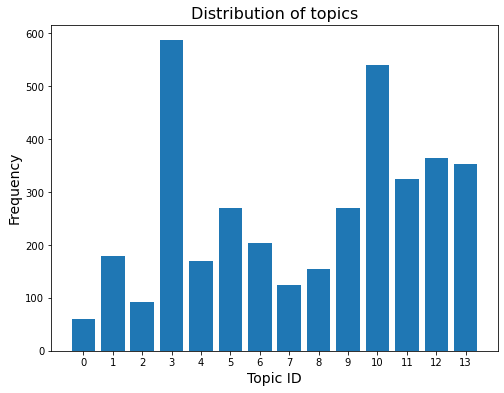

In [34]:
# Plot the topic distribution
plt.title("Distribution of topics")
plt.xlabel("Topic ID")
plt.ylabel("Frequency")
plt.bar(topics, counts, align = 'center')
plt.gca().set_xticks(topics)
plt.show()